In [1]:
print('Inicializando Variáveis do Programa')
#inicializando variáveis
#lista_confianças = [0.01]
lista_confianças = [0.01, 0.05]
variável_dependente = 'qty_2019'
variáveis_independentes = ('qty_2014', 'porcent_pagos')
ano_início = 2014
ano_fim = 2020
arquivo_indicadores_doutorado = "./indicadores_de_patentes.pkl"
max_variáveis_independentes_para_combinação = 5

lista_indicadores_a_ignorar = ['id', 
                                'index',
                                'pagtos',
                                'capes',
                                'indicador_tipo',
                                'indicador_grupo',
                                'indicador',
                                'qty_2012',
                                'qty_2013',
                                'qty_2014',
                                'qty_2015',
                                'qty_2016',
                                'qty_2017',
                                'qty_2018',
                                'qty_2019',
                                'tipo',
                                'nome',
                                'grupo',
                                'path',
                                'const',
                                'bool_cnpq',
                                'bool_capes',
                              ]


Inicializando Variáveis do Programa


In [2]:
from datetime import datetime
print('Início em: ', datetime.now())

print('Importações Iniciais')

from tkinter import NONE
from Lattes import Lattes
from Carga import Carga
from Database import Database
import psycopg2, pickle
import pandas, os
import statsmodels.api as sm
from urllib.parse import urlencode
from psycopg2.extensions import AsIs
from Carga import Carga
from pandas import pandas as pd
import numpy as np
import Database
import json, math
import locale
import statsmodels.formula.api as sm2
from itertools import combinations
from unidecode import unidecode



print('Fim: ', datetime.now())

Início em:  2023-05-25 10:05:17.370290
Importações Iniciais
Fim:  2023-05-25 10:05:20.460686


In [3]:
sql = '''
select * from financiamentos_doutorandos_2014
    inner join indicadores_doutorado
        on indicadores_doutorado.id = financiamentos_doutorandos_2014.id
    inner join indicadores_nomes
        on indicadores_nomes.tipo = indicadores_doutorado.indicador_tipo                 
'''

In [4]:
#Carregar arquivo na memória
print('Carregando indicadores na memória. Início em: ', datetime.now())

db = Database.Database('CNPq')
engine = Carga.db_engine()

dt = pd.read_sql(sql, engine)
print(f'dt.size: {dt.size}')

print('Término em: ', datetime.now())

Carregando indicadores na memória. Início em:  2023-05-25 10:05:20.516243
dt.size: 16139320
Término em:  2023-05-25 10:05:32.541936


In [5]:
sql_ids_pareados = '''
select pareado_1 as id from public.par_doutorandos_2014_sem_reposicao
UNION select pareado_2 as id from public.par_doutorandos_2014_sem_reposicao
UNION select pareado_3 as id from public.par_doutorandos_2014_sem_reposicao
'''

In [6]:
print('Carregando indicadores dos pareados na memória. Início em: ', datetime.now())

db = Database.Database('CNPq')
engine = Carga.db_engine()

pareados = pd.read_sql(sql_ids_pareados, engine)
print(f'dt.size: {dt.size}')

print('Término em: ', datetime.now())

Carregando indicadores dos pareados na memória. Início em:  2023-05-25 10:05:32.590816
dt.size: 16139320
Término em:  2023-05-25 10:05:32.806557


In [7]:
## Normalizando as Tabelas

print('Realizando normalização da tabela. Início em: ', datetime.now())

dt['const'] = 1
dt = dt.loc[:,~dt.columns.duplicated()]

dt['bool_cnpq'] = dt['pagtos'].map(lambda pagtos: 1 if pagtos > 0 else 0)
dt['bool_capes'] = dt['capes'].map(lambda capes: 1 if capes == True else 0)


#Preenchendo Nan com zeros nos indicadores
dt.qty_2012 = dt.qty_2012.fillna(0)
dt.qty_2013 = dt.qty_2013.fillna(0)
dt.qty_2014 = dt.qty_2014.fillna(0)
dt.qty_2015 = dt.qty_2015.fillna(0)
dt.qty_2016 = dt.qty_2016.fillna(0)
dt.qty_2017 = dt.qty_2017.fillna(0)
dt.qty_2018 = dt.qty_2018.fillna(0)
dt.qty_2019 = dt.qty_2019.fillna(0)
dt.capes = dt.capes.fillna(0)
dt.pagtos = dt.pagtos.fillna(0)

valor_total_cnpq =  dt[['id', 'pagtos']].loc[dt['pagtos']>0].drop_duplicates().sum().pagtos
dt['porcent_pagos'] = dt['pagtos']/valor_total_cnpq


print('Fim em: ', datetime.now())


Realizando normalização da tabela. Início em:  2023-05-25 10:05:32.841551
Fim em:  2023-05-25 10:05:33.991247


In [8]:
#Apagando os financiados pela CAPES
dt.drop(dt.loc[dt.bool_capes==True].index, inplace=True)

#Apagando os que não foram escolhidos pelo pareamento
dt.drop(dt.loc[~dt.id.isin(pareados.id)].loc[dt.pagtos==0].index, inplace=True)

In [9]:
def regressão(X,y):
    try:
        # OLS vem de Ordinary Least Squares e o método fit irá treinar o modelo
        reg = sm.OLS(y, X).fit()
        # mostrando as estatísticas do modelo
        #reg.summary()
        
        
        
        #guardando a regressão na memória

        result = {
                'Indicador': indicador,
                'Erro': False,
                'Prob (F-statistic)':reg.f_pvalue, 
                'Parâmetros': reg.params, 
                "P>|t|":reg.pvalues, 
                'Standard Error': reg.bse, 
                "Covariância entre os pasrâmetros": reg.normalized_cov_params, 
                'Number of observations n.': reg.nobs, 
                "R2 ajustado": reg.rsquared_adj, 
                "Modelo":reg.model,
            }
    except:
        result = {
                'Indicador': indicador,
                'Erro': True,
                'Prob (F-statistic)':None, 
                'Parâmetros': None, 
                "P>|t|":None, 
                'Standard Error': None, 
                "Covariância entre os pasrâmetros": None, 
                'Number of observations n.': None, 
                "R2 ajustado": None, 
                "Modelo": None,
            }
    return result

In [10]:
def regressão_r2(dados, variável_dependente, variáveis_independentes, menor_R2 = True, max_variáveis_independentes_para_combinação = 5):
    
    if not 'indicador' in locals(): indicador = ''
    lista_formulas = []
    num_combinações = 0
    if len(variáveis_independentes) < max_variáveis_independentes_para_combinação:
        max_variáveis_independentes_para_combinação = len(variáveis_independentes)
     
    if menor_R2:
        for x in range(1,max_variáveis_independentes_para_combinação):
            for a in combinations(variáveis_independentes,x):
                if not a[0] == '-1':
                    lista_formulas.append(faz_fórmula(variável_dependente, a))
                    num_combinações += 1
    else:
        lista_formulas = list(faz_fórmula(variável_dependente, variáveis_independentes))
        num_combinações += 1
    
    list_results = []
    curr = 0
    for formula in lista_formulas:
        curr += 1
        print(f'{curr}/{num_combinações}: {curr*100/num_combinações}%.')
    
        try:
            # OLS vem de Ordinary Least Squares e o método fit irá treinar o modelo
            reg_ajustado = sm2.ols(formula, data = dados)
            reg = reg_ajustado.fit()
            # mostrando as estatísticas do modelo
            print('\nCom constante:\n',reg.summary2())  

            #guardando a regressão na memória
            

            result = {
                    'Indicador': indicador,
                    'Erro': False,
                    'Prob (F-statistic)':reg.f_pvalue, 
                    'Parâmetros': reg.params, 
                    "P>|t|":reg.pvalues, 
                    'Standard Error': reg.bse, 
                    "Covariância entre os pasrâmetros": reg.normalized_cov_params, 
                    'Number of observations n.': reg.nobs, 
                    "R2 ajustado": 0 if reg.rsquared_adj is None else reg.rsquared_adj,
                    "Modelo":reg.model,
                }

        except:
            result = {
                    'Indicador': indicador,
                    'Erro': True,
                    'Prob (F-statistic)':None, 
                    'Parâmetros': None, 
                    "P>|t|":None, 
                    'Standard Error': None, 
                    "Covariância entre os pasrâmetros": None, 
                    'Number of observations n.': None, 
                    "R2 ajustado": 0, 
                    "Modelo": None,
                }
    
        list_results.append(result)
        
    print(list_results)
    if menor_R2:
        maiorR = max(list_results, key=lambda x:x['R2 ajustado'])
    else:
        maiorR = list_results[0]
        
        
    return maiorR, list_results

In [11]:
def regressão_com_confiança_2 (dados, 
                             variável_dependente, 
                             variáveis_independentes, 
                             confiança = 0.05,
                              menor_R2 = True,
                              max_variáveis_independentes_para_combinação = 5): 
    result, list_results = regressão_r2 (dados, 
                              variável_dependente, 
                              variáveis_independentes,
                              menor_R2, 
                          max_variáveis_independentes_para_combinação)

    while result['Erro'] == False and result['P>|t|'].max() > confiança:
        X = X.drop(columns=result['P>|t|'].idxmax())
        result = regressão(X,y)
        #print(result)
        
        
    if result['Erro'] == False and result['Prob (F-statistic)'] < confiança and result['P>|t|'].max() < confiança:
        result['Confiança'] = confiança
        return result
    else:
        result['Confiança'] = 'Erro'
    return result


In [45]:
# Para teste sobre se outros indicadores são significativoas no indicador 'Artigo Publicado'
#Cria tabela com os ids e cada indicador do ano de 2014, colocando 0 para os ausentes.
#O indicador de 2019 que permanece é o de 'Artigo Publicado'
#Assim, regressão pode ser realizada para saber 
#   quais indicadores se correlacionam com o estado de 'Artigo Publicado' no ano de 2019.

list_names = dt.nome.unique()
if os.path.isfile(arquivo_indicadores_doutorado):
    indicadores = pd.read_pickle(arquivo_indicadores_doutorado)  
else:      
    
    list_ind = []
    unique_ids = dt.id.unique()
    total = len(unique_ids)
    curr = 0
    
    #CONSTRUIR TABELA LENDO CADA LINHA DE UMA VEZ E ORGANIZANDO O DADO, AO INVÉS DE ITERAR MILHARES DE VEZXES SOBRE OS MESMOS DADOS.
    
    
    
    for id in unique_ids:
        #print(id)
        id_ind = dt.loc[dt.id==id]
        temp={
            'id': id,
            'porcent_pagos': id_ind.porcent_pagos.iloc[0],
            'pagtos': id_ind.pagtos.iloc[0],
            'capes': id_ind.capes.iloc[0],
            'bool_cnpq': id_ind.bool_cnpq.iloc[0],
            'bool_capes': id_ind.bool_capes.iloc[0],
        }
        for row in id_ind.iterrows():
            row = row[1]
            nome_indicador = row.nome
            for x in range(2012,2020):
                temp[f'{nome_indicador}_{x}'] = row[f'qty_{x}']
         
        list_ind.append(temp)
        curr += 1
        if curr%10 == 0:
            print (f'{curr}/{total}: {curr*100/total}% done.')
    indicadores = pd.DataFrame(list_ind)
    del list_ind
    columns = {}
    for column in indicadores:
        new_column_name = unidecode(column.lower().replace(' ', '_').replace(',', '_').replace('/', '_').replace('-', '_'))
        lista_colunas_nomes_para_alterar = new_column_name
        columns[column] = lista_colunas_nomes_para_alterar
    indicadores.rename(columns=columns, inplace=True)
    indicadores.to_pickle(arquivo_indicadores_doutorado) 
list_variáveis_independentes = list(variáveis_independentes)
for column in indicadores:
    list_variáveis_independentes.extend([column])

    
#Faz lista com os nomes das colunas para analisar apenas os anos que quiser
nome_colunas = {}
    
for x in range(2012,2020):
    nome_colunas[x] = []
    for col in indicadores.columns:
        if str(x) in str(col):
            nome_colunas[x].append(col)

10/4836: 0.20678246484698098% done.
20/4836: 0.41356492969396197% done.
30/4836: 0.6203473945409429% done.
40/4836: 0.8271298593879239% done.
50/4836: 1.0339123242349049% done.
60/4836: 1.2406947890818858% done.
70/4836: 1.4474772539288667% done.
80/4836: 1.6542597187758479% done.
90/4836: 1.8610421836228288% done.
100/4836: 2.0678246484698097% done.
110/4836: 2.2746071133167907% done.
120/4836: 2.4813895781637716% done.
130/4836: 2.6881720430107525% done.
140/4836: 2.8949545078577335% done.
150/4836: 3.101736972704715% done.
160/4836: 3.3085194375516958% done.
170/4836: 3.5153019023986767% done.
180/4836: 3.7220843672456576% done.
190/4836: 3.9288668320926385% done.
200/4836: 4.1356492969396195% done.
210/4836: 4.3424317617866% done.
220/4836: 4.549214226633581% done.
230/4836: 4.755996691480562% done.
240/4836: 4.962779156327543% done.
250/4836: 5.169561621174524% done.
260/4836: 5.376344086021505% done.
270/4836: 5.583126550868486% done.
280/4836: 5.789909015715467% done.
290/4836: 

2320/4836: 47.97353184449959% done.
2330/4836: 48.18031430934657% done.
2340/4836: 48.38709677419355% done.
2350/4836: 48.59387923904053% done.
2360/4836: 48.80066170388751% done.
2370/4836: 49.007444168734494% done.
2380/4836: 49.214226633581475% done.
2390/4836: 49.421009098428456% done.
2400/4836: 49.62779156327544% done.
2410/4836: 49.83457402812242% done.
2420/4836: 50.0413564929694% done.
2430/4836: 50.24813895781638% done.
2440/4836: 50.45492142266336% done.
2450/4836: 50.66170388751034% done.
2460/4836: 50.86848635235732% done.
2470/4836: 51.075268817204304% done.
2480/4836: 51.282051282051285% done.
2490/4836: 51.488833746898266% done.
2500/4836: 51.69561621174525% done.
2510/4836: 51.90239867659223% done.
2520/4836: 52.10918114143921% done.
2530/4836: 52.31596360628619% done.
2540/4836: 52.52274607113317% done.
2550/4836: 52.72952853598015% done.
2560/4836: 52.93631100082713% done.
2570/4836: 53.14309346567411% done.
2580/4836: 53.349875930521094% done.
2590/4836: 53.55665839

4650/4836: 96.15384615384616% done.
4660/4836: 96.36062861869314% done.
4670/4836: 96.56741108354012% done.
4680/4836: 96.7741935483871% done.
4690/4836: 96.98097601323408% done.
4700/4836: 97.18775847808107% done.
4710/4836: 97.39454094292805% done.
4720/4836: 97.60132340777503% done.
4730/4836: 97.80810587262201% done.
4740/4836: 98.01488833746899% done.
4750/4836: 98.22167080231597% done.
4760/4836: 98.42845326716295% done.
4770/4836: 98.63523573200993% done.
4780/4836: 98.84201819685691% done.
4790/4836: 99.0488006617039% done.
4800/4836: 99.25558312655087% done.
4810/4836: 99.46236559139786% done.
4820/4836: 99.66914805624484% done.
4830/4836: 99.87593052109182% done.


In [67]:
indicadores

,id,porcent_pagos,pagtos,capes,bool_cnpq,bool_capes,conclusao_de_doutorado_2012,conclusao_de_doutorado_2013,conclusao_de_doutorado_2014,conclusao_de_doutorado_2015,...,solicitacao_de_cultivar_protegida_2018,solicitacao_de_cultivar_protegida_2019,obtencao_do_titulo_de_mba_2012,obtencao_do_titulo_de_mba_2013,obtencao_do_titulo_de_mba_2014,obtencao_do_titulo_de_mba_2015,obtencao_do_titulo_de_mba_2016,obtencao_do_titulo_de_mba_2017,obtencao_do_titulo_de_mba_2018,obtencao_do_titulo_de_mba_2019
0,1074831861726,0.000403,116730.0,False,1,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1710013962811,0.000000,0.0,False,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2418054837066,0.000000,0.0,False,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3223819899291,0.000000,0.0,False,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3801791761838,0.000206,59662.0,False,1,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,9991677557621925,0.000000,0.0,False,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4832,9994608369539105,0.000403,116730.0,False,1,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4833,9997230701640391,0.000429,124512.0,False,1,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4834,9998457346711166,0.000000,0.0,False,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import factor_analyzer

In [184]:
data_artigos = indicadores
for column in data_artigos:
    for ano in range (2012,2020):
        if ano == 2014: pass
        elif ano == 2019:
            if str(ano) in column and not 'artigos' in column:
                data_artigos = data_artigos.drop([column], axis=1)
        else:
            if str(ano) in column:
                data_artigos = data_artigos.drop([column], axis=1)
data_artigos = data_artigos.fillna(0)
data_artigos = data_artigos.loc[ ~data_artigos.isin([np.nan, np.inf, -np.inf]).any(1)]

In [186]:
list_columns = [
'id',
'pagtos',
'capes',
'bool_cnpq',
'bool_capes',
]
for l in list_columns:
    try:
        data_artigos = data_artigos.drop([l], axis=1)
    except:
        pass


In [187]:
data = data_artigos


In [290]:
for c in data:
    print(c)

porcent_pagos
conclusao_de_doutorado_2014
conclusao_de_curso_de_curta_duracao_2014
conclusao_de_graduacao_2014
conclusao_de_mestrado_2014
inicio_de_doutorado_2014
inicio_de_curso_de_curta_duracao_2014
inicio_de_graduacao_2014
inicio_de_mestrado_2014
inicio_de_pos_doutorado_2014
obtencao_do_titulo_de_doutorado_2014
obtencao_do_titulo_de_metrado_2014
detalhamento_do_trabalho_2014
artigo_publicado_2014
trabalho_em_eventos_2014
fim_de_estagio_2014
fim_de_atividade_de_pesquisa_e_desenvolvimento_2014
fim_de_vinculo_empregaticio_ou_funcional_2014
inicio_de_atividade_de_ensino_2014
inicio_de_estagio_2014
inicio_de_atividade_de_pesquisa_e_desenvolvimento_2014
inicio_de_vinculo_empregaticio_ou_funcional_2014
apresentacao_de_trabalho_tecnico_2014
publicacao_de_capitulo_de_livro_2014
livro_publicado_ou_organizado_2014
outras_orientacoes_concluidas_2014
participacao_em_congresso_2014
participacao_em_seminario_2014
participacao_em_simposio_2014
premio_ou_titulo_recebido_2014
conclusao_de_outra_forma

In [280]:
data = data_artigos[['porcent_pagos', 
                          'conclusao_de_doutorado_2014',
                          'conclusao_de_curso_de_curta_duracao_2014',
'conclusao_de_graduacao_2014',
'conclusao_de_mestrado_2014',
'inicio_de_doutorado_2014',
'inicio_de_curso_de_curta_duracao_2014',
'inicio_de_graduacao_2014',
'inicio_de_mestrado_2014',
'inicio_de_pos_doutorado_2014',
'obtencao_do_titulo_de_doutorado_2014',
'obtencao_do_titulo_de_metrado_2014',
'detalhamento_do_trabalho_2014',
'artigo_publicado_2014',
'trabalho_em_eventos_2014',
'fim_de_estagio_2014',
'fim_de_atividade_de_pesquisa_e_desenvolvimento_2014',
'fim_de_vinculo_empregaticio_ou_funcional_2014',
'inicio_de_atividade_de_ensino_2014',
'inicio_de_estagio_2014',
'inicio_de_atividade_de_pesquisa_e_desenvolvimento_2014',
'inicio_de_vinculo_empregaticio_ou_funcional_2014',
'apresentacao_de_trabalho_tecnico_2014',
'publicacao_de_capitulo_de_livro_2014',
'livro_publicado_ou_organizado_2014',
'outras_orientacoes_concluidas_2014',
'participacao_em_congresso_2014',
'participacao_em_seminario_2014',
'participacao_em_simposio_2014',
'premio_ou_titulo_recebido_2014',
'conclusao_de_outra_formacao_complementar_2014',
'inicio_de_outra_formacao_complementar_2014',
'organizacao_de_evento_2014',
'outras_participacoes_em_congressos_2014',
'participacao_em_banca_de_graduacao_2014',
'conclusao_de_especializacao_2014',
'conclusao_de_extensao_universitaria_2014',
'inicio_de_especializacao_2014',
'inicio_de_extensao_universitaria_2014',
'fim_de_atividade_de_ensino_2014',
'fim_de_participacao_em_projeto_2014',
'fim_de_projeto_de_pesquisa_2014',
'inicio_de_participacao_em_projeto_2014',
'inicio_de_projeto_de_pesquisa_2014',
'ministerio_de_curso_de_curta_duracao_2014',
'desenvolvimento_de_material_didatico_ou_instrucional_2014',
'outra_producao_tecnica_2014',
'outras_participacoes_de_bancas_julgadoras_2014',
'participacao_em_encontro_2014',
'participacao_em_exposicao_2014',
'publicacao_de_prefacio_ou_posfacio_2014',
'programa_de_radio_ou_tv_2014',
'midia_social__websiteou_blog_2014',
'participacao_em_banca_de_aperfeicoamento_ou_especializacao_2014',
'participacao_em_banca_de_exame_de_qualificacao_2014',
'participacao_em_banca_de_mestrado_2014',
'participacao_em_oficina_2014',
'producao_de_trabalho_tecnico_2014',
'conclusao_de_ensino_medio_2014',
'inicio_de_ensino_medio_2014',
'artigo_aceito_para_publicacao_2014',
'participacao_em_banca_julgadora_para_concurso_publico_2014',
'orientacao_em_andamento_de_graduacao_2014',
'producao_bibliografica_2014',
'participacao_em_banca_de_doutorado_2014',
'producao_de_relatorio_de_pesquisa_2014',
'fim_de_atividade_de_servico_tecnico_especializado_2014',
'inicio_de_atividade_de_servico_tecnico_especializado_2014',
'conclusao_de_curso_tecnico_profissionalizante_2014',
'inicio_de_curso_tecnico_profissionalizante_2014',
'texto_em_jornal_ou_revista_2014',
'orientacao_concluida_de_doutorado_2014',
'orientacao_concluida_de_mestrado_2014',
'traducao_2014',
'producao_de_artes_visuais_2014',
'producao___demais_trabalhos_2014',
'producao_artistica_ou_cultural_2014',
'inicio_de_atividade_de_direcao_ou_administracao_2014',
'fim_de_extensao_universitaria_2014',
'fim_de_outra_atividade_tecnico_cientifica_2014',
'inicio_de_outra_atividade_tecnico_cientifica_2014',
'fim_de_participacao_em_conselho__comissao_ou_consultoria_2014',
'inicio_de_atividade_de_conselho__comissao_ou_consultoria_2014',
'orientacao_em_andamento_de_mestrado_2014',
'orientacao_em_andamento_de_iniciacao_cientifica_2014',
'participacao_em_feira_2014',
'patente_registrada_2014',
'conclusao_de_aperfeicoamento_2014',
'inicio_de_aperfeicoamento_2014',
'editoracao_2014',
'orientacao_em_andamento_de_aperfeicoamento_ou_especializacao_2014',
'conclusao_de_ensino_fundamental_2014',
'inicio_de_ensino_fundamental_2014',
'participacao_em_banca_julgadora_para_avaliacao_de_cursos_2014',
'fim_de_participacao_em_direcao_ou_administracao_2014',
'conclusao_de_mba_2014',
'inicio_de_mba_2014',
'outras_orientacoes_em_andamento_2014',
'producao_de_software_2014',
'orientacao_em_andamento_de_doutorado_2014',
'conclusao_de_residencia_medica_2014',
'inicio_de_residencia_medica_2014', #
'conclusao_de_mestrado_profissionalizante_2014',
'inicio_de_mestrado_profissionalizante_2014', #
'obtencao_do_titulo_de_mestrado_profissionalizante_2014',
'treinamento_ministrado_2014', #
'inicio_de_ministerio_de_treinamento_2014', #
'participacao_em_olimpiada_2014', #
#'conclusao_de_pos_doutorado_2014', #---
'producao_de_artes_cenicas_2014', 
'musica_2014',
'desenvolvimento_de_marca_2014',
'producao_tecnica___produto_tecnologico_2014',
#'orientacao_em_andamento_de_pos_doutorado_2014',
'participacao_em_banca_julgadora_para_professor_titular_2014',
'producao_de_carta__mapa_ou_similar_2014',
'producao_tecnica___processos_ou_tecnicas_2014',
'producao__de_obra_musical_2014',
'publicacao_de_partitura_musical_2014',
'maquete_2014',
'participacao_em_banca_julgadora_para_livre_docencia_2014',
'obtencao_do_titulo_de_livre_docencia_2014',
#'orientacao_concluida_de_pos_doutorado_2014',
'solicitacao_de_cultivar_registrada_2014',
'manutencao_de_obra_artistica_2014',
'outras_participacoes_em_banca_2014',
'desenvolvimento_de_desenho_industrial_2014',
#'solicitacao_de_cultivar_protegida_2014',
            ]]

In [281]:
fa = FactorAnalyzer(rotation='varimax')
fa.fit(data)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [282]:
eigenvalues = factor_analyzer.get_eigenvalues()


In [283]:
print(eigenvalues)


(array([2.98473791e+00, 2.18801635e+00, 1.89993437e+00, 1.39170882e+00,
       1.32649642e+00, 1.00301109e+00, 9.85794827e-01, 9.58571970e-01,
       6.08442820e-01, 4.58917531e-01, 1.04733837e-01, 5.29052826e-02,
       3.65119386e-02, 2.16838429e-04]), array([ 2.88862811e+00,  2.08938868e+00,  1.80348348e+00,  5.22594138e-01,
        4.00382135e-01,  8.96334117e-03,  6.55947262e-04, -1.17240150e-03,
       -6.52485011e-03, -1.00903788e-02, -2.91882816e-02, -3.39177853e-02,
       -3.84576367e-01, -4.67120970e-01]))


In [284]:
factor_analyzer = FactorAnalyzer(n_factors=3, rotation='varimax')
factor_analyzer.fit(data)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [117]:
# Obtendo os valores próprios
eigenvalues = factor_analyzer.get_eigenvalues()

# Exibindo os valores próprios
print("Valores próprios:", eigenvalues)

# Verificando quais valores próprios são maiores que 1
significant_eigenvalues = eigenvalues[eigenvalues > 1]
print("Valores próprios significativos:", significant_eigenvalues)

Valores próprios: (array([2.98473791e+00, 2.18801635e+00, 1.89993437e+00, 1.39170882e+00,
       1.32649642e+00, 1.00301109e+00, 9.85794827e-01, 9.58571970e-01,
       6.08442820e-01, 4.58917531e-01, 1.04733837e-01, 5.29052826e-02,
       3.65119386e-02, 2.16838429e-04]), array([ 2.88862811e+00,  2.08938868e+00,  1.80348348e+00,  5.22594138e-01,
        4.00382135e-01,  8.96334117e-03,  6.55947262e-04, -1.17240150e-03,
       -6.52485011e-03, -1.00903788e-02, -2.91882816e-02, -3.39177853e-02,
       -3.84576367e-01, -4.67120970e-01]))


TypeError: '>' not supported between instances of 'tuple' and 'int'

In [289]:


# Calcular os valores de KMO (Kaiser-Meyer-Olkin)
kmo_score, kmo_model = factor_analyzer.factor_analyzer.calculate_kmo(data)
print("KMO score:", kmo_score, kmo_model)

# Calcular a matriz de cargas fatoriais
factor_loadings = factor_analyzer.loadings_
print("Matriz de Cargas Fatoriais:\n", factor_loadings)


KMO score: [0.83740839 0.58128695 0.66396257 0.5567506  0.71934981 0.6159736
 0.66423066 0.55135022 0.83388598 0.53294783 0.62089164 0.82297807
 0.76380041 0.93902577 0.76327489 0.617375   0.58830022 0.73670546
 0.664453   0.61885304 0.66115315 0.76232976 0.94433835 0.85666637
 0.73979163 0.80753391 0.93671047 0.93448994 0.93484536 0.90563334
 0.59622114 0.59823651 0.93603665 0.91464765 0.75617363 0.63797319
 0.51310202 0.63443439 0.54115575 0.65919119 0.68952619 0.68759054
 0.69919696 0.69466462 0.89518602 0.81114767 0.83625968 0.88780559
 0.92407696 0.71807709 0.67177144 0.73518071 0.58564133 0.80141913
 0.61325252 0.54245855 0.85414689 0.7905053  0.64790109 0.64763582
 0.6849422  0.89991486 0.63741119 0.83344503 0.49997691 0.87398423
 0.59302147 0.59786358 0.514506   0.51487129 0.74661486 0.59418048
 0.57116784 0.55212787 0.81646798 0.7729436  0.75553086 0.65361021
 0.62615598 0.58542546 0.59283674 0.69661059 0.7053051  0.33956981
 0.48959407 0.58301225 0.60712396 0.55074574 0.55101

AttributeError: module 'factor_analyzer' has no attribute 'loadings_'

In [52]:
iris = datasets.load_iris()
 
target_names = {
    0:'setosa',
    1:'versicolor', 
    2:'virginica'
}
 
df = pd.DataFrame(
    iris.data, 
    columns=iris.feature_names
    )
 
df['target'] = iris.target
df['target_names'] = df['target'].map(target_names)

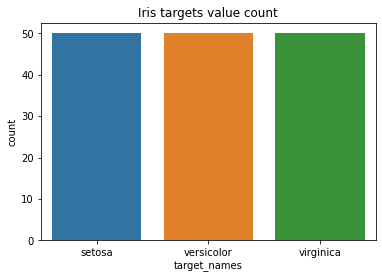

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns 
 
sns.countplot(
    x='target_names', 
    data=df)
plt.title('Iris targets value count')
plt.show()

In [58]:
from sklearn import datasets
 
# load features and targets separately
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [64]:
# data scaling
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler().fit_transform(X)

In [65]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=3)
 
pca_features = pca.fit_transform(x_scaled)
 
print('Shape before PCA: ', x_scaled.shape)
print('Shape after PCA: ', pca_features.shape)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])

Shape before PCA:  (150, 4)
Shape after PCA:  (150, 3)


In [66]:
pca_df

,PC1,PC2,PC3
0,-2.264703,0.480027,-0.127706
1,-2.080961,-0.674134,-0.234609
2,-2.364229,-0.341908,0.044201
3,-2.299384,-0.597395,0.091290
4,-2.389842,0.646835,0.015738
...,...,...,...
145,1.870503,0.386966,0.256274
146,1.564580,-0.896687,-0.026371
147,1.521170,0.269069,0.180178
148,1.372788,1.011254,0.933395


In [41]:
curr = 0
temp={}
for row in id_ind.iterrows():
    row = row[1]
    curr +=1
    nome_indicador = row.nome
    for x in range(2012,2020):
        temp[f'{nome_indicador}_{x}'] = row[f'qty_{x}']
    if curr > 10:break
temp

{'Conclusão de Doutorado_2012': 0.0,
 'Conclusão de Doutorado_2013': 0.0,
 'Conclusão de Doutorado_2014': 0.0,
 'Conclusão de Doutorado_2015': 0.0,
 'Conclusão de Doutorado_2016': 0.0,
 'Conclusão de Doutorado_2017': 0.0,
 'Conclusão de Doutorado_2018': 1.0,
 'Conclusão de Doutorado_2019': 1.0,
 'Conclusão de Curso de Curta Duração_2012': 0.0,
 'Conclusão de Curso de Curta Duração_2013': 2.0,
 'Conclusão de Curso de Curta Duração_2014': 2.0,
 'Conclusão de Curso de Curta Duração_2015': 3.0,
 'Conclusão de Curso de Curta Duração_2016': 3.0,
 'Conclusão de Curso de Curta Duração_2017': 3.0,
 'Conclusão de Curso de Curta Duração_2018': 3.0,
 'Conclusão de Curso de Curta Duração_2019': 3.0,
 'Conclusão de Graduação_2012': 2.0,
 'Conclusão de Graduação_2013': 2.0,
 'Conclusão de Graduação_2014': 2.0,
 'Conclusão de Graduação_2015': 2.0,
 'Conclusão de Graduação_2016': 2.0,
 'Conclusão de Graduação_2017': 2.0,
 'Conclusão de Graduação_2018': 2.0,
 'Conclusão de Graduação_2019': 2.0,
 'Conclu

In [ ]:
def faz_fórmula(variável_dependente, a):
    
    formula = f'{variável_dependente} ~ '
    for dado in a:
        if dado not in (lista_indicadores_a_ignorar):
            formula = formula + f'{dado} + '
    formula = formula[:-3]    
    
    return formula

In [ ]:
p_max_value = 1
for ind in lista_indicadores_a_ignorar:
    try:
        list_variáveis_independentes.remove(ind)
        print(f'\nEliminando a chave {ind}, que está na lista de eliminação.') 
    except:
        pass
while p_max_value > 0.01 and len (list_variáveis_independentes) > 0:
    formula = faz_fórmula(variável_dependente, list_variáveis_independentes)

    reg_ajustado = sm2.ols(formula, data = indicadores)
    reg = reg_ajustado.fit()
    # mostrando as estatísticas do modelo
    
    max_p = reg.pvalues.nlargest(1)
    p_max_value = max_p.values[0]
    p_max_key = max_p.keys()[0]
    if p_max_value < 0.01: 
        print(f'\nNenhuma chave a eliminar. Terminando. Maior P|t| = {p_max_value} é a chave {p_max_key}.')
        break
    
    print(f'\nEliminando a chave {p_max_key} com P|t| = {p_max_value}.') 
    list_variáveis_independentes.remove(p_max_key)   
    
    for k, v in reg.pvalues.iteritems():
        if math.isnan(v):
            print(f'\nEliminando a chave {k} com P|t| = {v}.') 
            list_variáveis_independentes.remove(k)   

len(list_variáveis_independentes)

In [ ]:
reg.summary2()